In [1]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import random
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from pytorch_lightning import Trainer
import os
import numpy as np
import pandas as pd
from os.path import join
from typing import Optional
from config import processed_data_path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm
from optuna.integration import PyTorchLightningPruningCallback
from scipy.stats import wasserstein_distance 
import joblib
import optuna
%matplotlib inline
from matplotlib import pyplot as plt
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import r2_score
from scipy.stats import wasserstein_distance
import threading
import concurrent
from sklearn.metrics import r2_score
from VAE_OPTIMIZATION_WD import _dataset, VAE, study, compare_continuous, compare_integer#, compare_distributions_binned_aux, compare_distributions_binned

[I 2021-08-02 09:51:30,299] Using an existing study with name 'Optimizing the VAE with WD - BKG vs Random Sampling' instead of creating a new one.


## Loading the Study

In [2]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

print(" TRIAL NUMBER:", trial.number)

Number of finished trials: 108
Best trial:
  Value: 10.894459985720914
  Params: 
    alpha: 221
    hidden_size: 40
    lr: 0.0005118528891017186
    n_layers_decoder: 6
    n_layers_encoder: 3
    n_units_decoder_l0: 5
    n_units_decoder_l1: 305
    n_units_decoder_l2: 135
    n_units_decoder_l3: 225
    n_units_decoder_l4: 395
    n_units_decoder_l5: 155
    n_units_encoder_l0: 380
    n_units_encoder_l1: 360
    n_units_encoder_l2: 240
 TRIAL NUMBER: 51


### Optuna Graphs

In [3]:
optuna.visualization.plot_param_importances(study) 

In [4]:
optuna.visualization.plot_optimization_history(study)

## Anomaly Detection

### Load the model

In [5]:
# Nao é o 49, 53, 33, 26, 25, 23, 22, 16
#name = "wd-sample_vs_data_trial_16"
#name = "wd-sample_vs_data_trial_{}".format(trial.number)
name = "CustomTrain_WD-Data_vs_Sampling_trial_51"
model = VAE.load_from_checkpoint(
    #join('models', f"sample_vs_data_trial_{study.best_trial.number}.ckpt"),
    join("models", name + ".ckpt"),
    #trial = study.trials[16], 
    trial = optuna.trial.FixedTrial(study.best_trial.params), 
    dataset = "bkg", 
    batch_size=512)

model.eval()

/home/acujl/.local/lib/python3.8/site-packages/optuna/distributions.py:560: UserWarning:

The distribution is specified by [1, 10000] and step=5, but the range is not divisible by `step`. It will be replaced by [1, 9996].

/home/acujl/.local/lib/python3.8/site-packages/optuna/distributions.py:560: UserWarning:

The distribution is specified by [5, 500] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 495].



VAE(
  (encoder): Sequential(
    (0): Linear(in_features=69, out_features=380, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=380, out_features=360, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=360, out_features=240, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=240, out_features=40, bias=True)
  )
  (hidden2mu): Linear(in_features=40, out_features=40, bias=True)
  (hidden2log_var): Linear(in_features=40, out_features=40, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=40, out_features=5, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=5, out_features=305, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=305, out_features=135, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=135, out_features=225, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=225, ou

### Load data

In [6]:
# Bkg
bkg = _dataset(category='validation',variant='bkg').all_data() # The data category is validation because I accidentally used 'test' on the validation step while training
bkg_name = bkg['name']
bkg_weights = bkg['weights']
bkg.drop(columns=['weights', 'name'], inplace=True)
bkg.shape

(341121, 69)

## Check if z ~ N(0,1)

In [7]:
_, _, x_out, hidden = model.test_step(torch.from_numpy(bkg.to_numpy(dtype=np.float32)))
x_out = x_out.detach().numpy()
hidden = hidden.detach().numpy()
hidden.shape

(341121, 40)

<ipython-input-8-cccee3f30eb4>:11: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



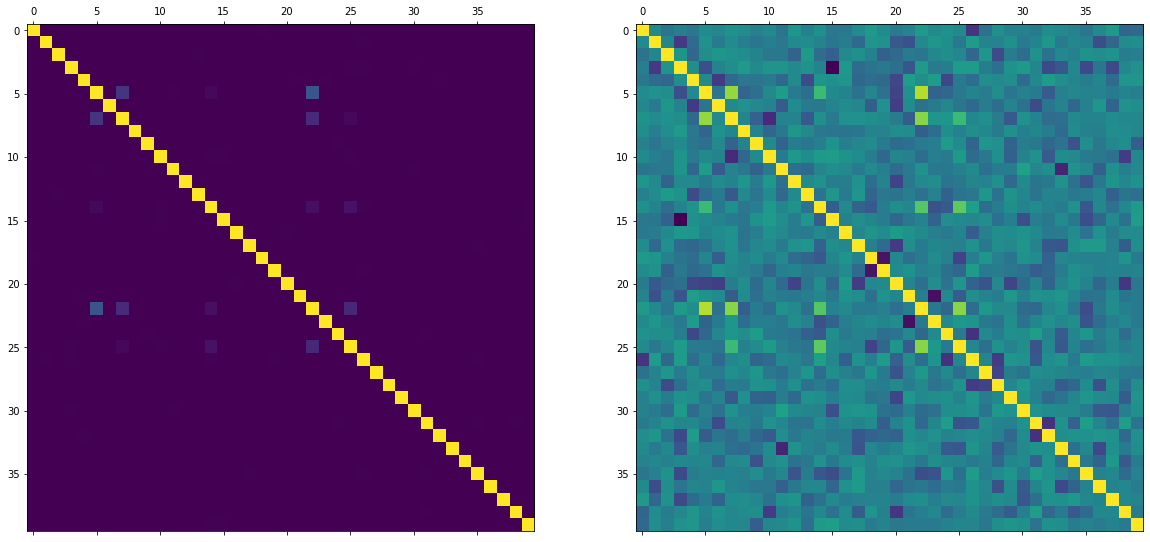

In [8]:
fig = plt.figure(figsize=[20,15])
i = 0

axes = fig.add_subplot(1,2,i+1)
i += 1
axes.matshow(pd.DataFrame(hidden).corr().apply(abs))

axes = fig.add_subplot(1,2,i+1)
i += 1
axes.matshow(pd.DataFrame(hidden).corr().apply(abs).apply(np.log))
fig.show()

In [9]:
corr = pd.DataFrame(hidden).corr().apply(abs)
corr.replace(1, 0, inplace=True)

print("Max:\t", round(corr.max().max(), 5))
print("Mean:\t", round(corr.mean().mean(), 5))

Max:	 0.26364
Mean:	 0.00231


Mean: 0.0006846067 	Std: 1.0015454
Mean: -0.0016390701 	Std: 0.9998084
Mean: 0.00045482372 	Std: 1.000152
Mean: -0.0005938328 	Std: 1.0021808
Mean: -0.0010726022 	Std: 0.99933934
Mean: -0.44219917 	Std: 0.8305206
Mean: -0.0012130027 	Std: 0.99999267
Mean: 0.14586526 	Std: 0.96225584
Mean: -0.00038969173 	Std: 1.0006789
Mean: -0.0020143057 	Std: 1.000513
Mean: 0.0011956253 	Std: 1.0000414
Mean: -0.0042138463 	Std: 0.9995408
Mean: 0.00049646903 	Std: 0.9989761
Mean: -0.00017252966 	Std: 0.9997334
Mean: 0.09190968 	Std: 0.99715894
Mean: -0.0011244186 	Std: 1.0003303
Mean: 0.0024746535 	Std: 1.0001689
Mean: 0.0010223389 	Std: 1.0008951
Mean: 0.0014660244 	Std: 1.0002321
Mean: 0.0021543622 	Std: 0.99941456
Mean: -0.0018876351 	Std: 0.9989308
Mean: 0.0016535204 	Std: 0.99673146
Mean: 0.24648467 	Std: 0.91948813
Mean: -0.00045427083 	Std: 0.99977094
Mean: -0.0005796026 	Std: 0.99994546
Mean: 0.046805546 	Std: 0.9905578
Mean: 0.0007981688 	Std: 1.0005537
Mean: -0.00092137005 	Std: 1.0008128
Me

<ipython-input-10-3e65db6d3c91>:20: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



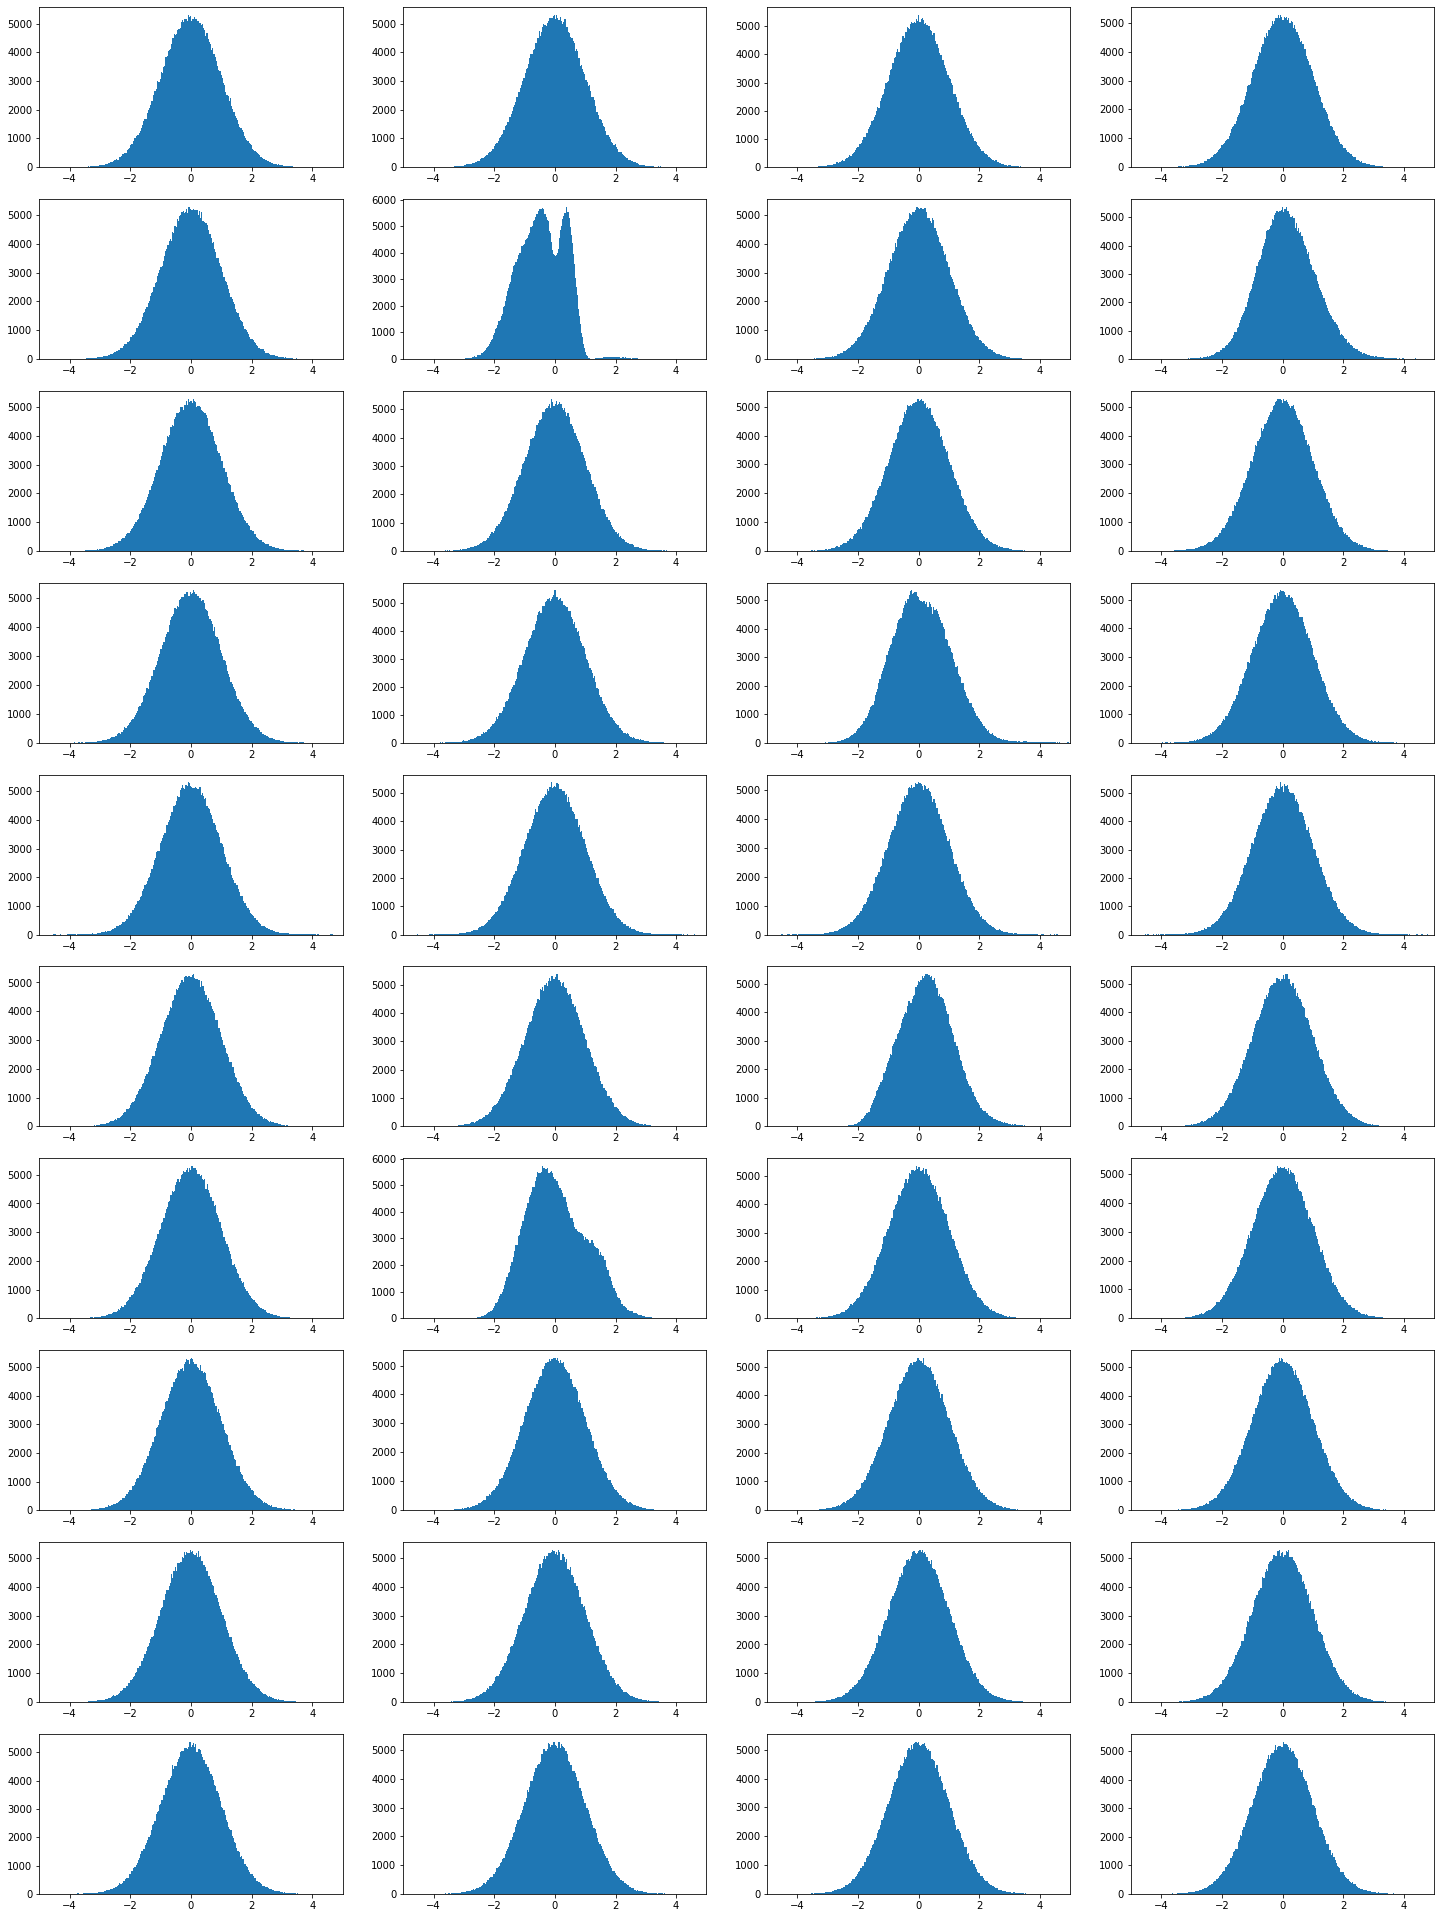

In [10]:

fig = plt.figure(figsize=[25,70])
i = 0

total_mean = []
total_std = []
for x in range(hidden.shape[1]):
    axes = fig.add_subplot(20,4,i+1)
    i += 1

    axes.hist(hidden[:, x], bins='auto')
    axes.axis(xmin=-5,xmax=5)
    #axes.title(f"Z{x}")
    total_mean.append(hidden[:, x].mean())
    total_std.append(hidden[:, x].std())
    print("Mean:", hidden[:, x].mean(), "\tStd:", hidden[:, x].std())

print("\n")
print("Total average mean", np.array(total_mean).mean())
print("Total average std", np.array(total_std).mean())
fig.show()

## Bkg Data vs Random Sampling Decoding

In [11]:
# Random sample from N(0,1)
sample = model.decode(torch.rand(bkg.shape[0], study.best_trial.params['hidden_size'])).detach().numpy()

# Make it a dataframe
sample = pd.DataFrame(sample, columns=bkg.columns)
sample.describe()

,Electron1_Eta,Electron1_PT,Electron1_Phi,Electron2_Eta,Electron2_PT,Electron2_Phi,Electron_Multi,FatJet1_Eta,FatJet1_Mass,FatJet1_PT,...,MissingET_MET,MissingET_Phi,Muon1_Eta,Muon1_PT,Muon1_Phi,Muon2_Eta,Muon2_PT,Muon2_Phi,Muon_Multi,ScalarHT_HT
count,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,...,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000,341121.000000
mean,-0.671501,1.719481,-1.257883,-0.713446,0.571642,-0.928954,1.119550,-0.375458,-0.053953,1.016769,...,0.000849,0.293005,-0.119257,-0.871261,-0.115274,-0.107599,-0.726845,0.033076,-1.133614,1.009637
std,1.392134,0.997129,0.798138,1.496717,0.667262,1.144562,0.382865,0.904032,0.653485,0.546031,...,0.163104,0.288648,0.478155,0.373569,0.147786,0.375380,0.253736,0.254093,0.418906,0.608389
min,-3.692110,-0.958605,-3.306175,-3.967299,-1.031321,-3.759036,-0.958977,-2.278379,-1.186529,-0.413853,...,-0.493861,-0.523196,-2.485691,-1.722509,-0.961011,-2.867280,-2.078521,-1.781162,-1.511816,-0.753383
25%,-1.835399,0.939406,-1.908932,-1.903235,0.233635,-1.858263,1.146639,-1.163578,-0.586370,0.611848,...,-0.105649,0.073061,-0.083945,-1.060277,-0.198497,-0.096869,-0.854442,-0.074519,-1.327771,0.576140
50%,-0.605674,1.763704,-1.207149,-0.625727,0.513873,-0.761228,1.251666,-0.352557,-0.193972,1.005856,...,-0.025841,0.284128,0.001229,-0.928069,-0.101308,-0.004595,-0.770519,0.051569,-1.283441,1.002201
75%,0.482426,2.424936,-0.632472,0.458478,0.829718,-0.095912,1.295962,0.379528,0.408939,1.405909,...,0.075522,0.489724,0.053691,-0.807240,-0.017075,0.045282,-0.674448,0.188938,-1.164103,1.430631
max,2.592852,4.804201,1.081755,3.044215,4.109749,1.880967,1.472864,1.728882,2.094557,2.773096,...,0.759719,1.288585,0.756206,1.436621,0.539023,0.504757,1.299728,1.068744,1.073260,3.069850


In [12]:
def plot_graphs2(background, signal, bins=50, num_cols=4, first_name="Signal", second_name="Sampled"):
    WD_SCORE = 0
    R2_SCORE = 0
    # Ignoring irrelevant features such as 'name' and 'weights' in
    # the plotting of the data
    features  = list(background.columns)
    for x in ['name', 'weights']: 
        try:
            features.remove(x)
        except:
            pass

    # Plot creation
    num_rows = int(np.ceil((len(list(background.columns)) - 1) / num_cols)) +1
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(40, 60))
    i= 0

    for x in tqdm(features, total=len(features), desc="Processing..."):

        # Plot  
        row, col = int(i/num_cols), i%num_cols
        #print(row, col, i)
        i += 1


        # Define histogram range
        hist_min = min(signal[x].min(), background[x].min())
        hist_max = max(signal[x].max(), background[x].max())
        hist_range = (hist_min, hist_max)


        ax[row, col].set_title(x)
        ax[row, col].set_yscale('log')
        
        ax[row, col].hist(background[x], bins=bins, alpha=0.5, label=first_name, range=hist_range)
        ax[row, col].hist(signal[x], bins=bins, alpha=0.5, label=second_name,  range=hist_range)
        
        ax[row, col].autoscale(enable=True) 
        ax[row, col].legend()

        #WD_SCORE += wasserstein_distance(background[x], signal[x])
        #R2_SCORE += r2_score(background[x],signal[x])
        

    fig.tight_layout()
    #plt.savefig('1_explore_data.png', bbox_inches='tight', dpi=100)
    plt.show()

Processing...:   0%|          | 0/69 [00:00<?, ?it/s]

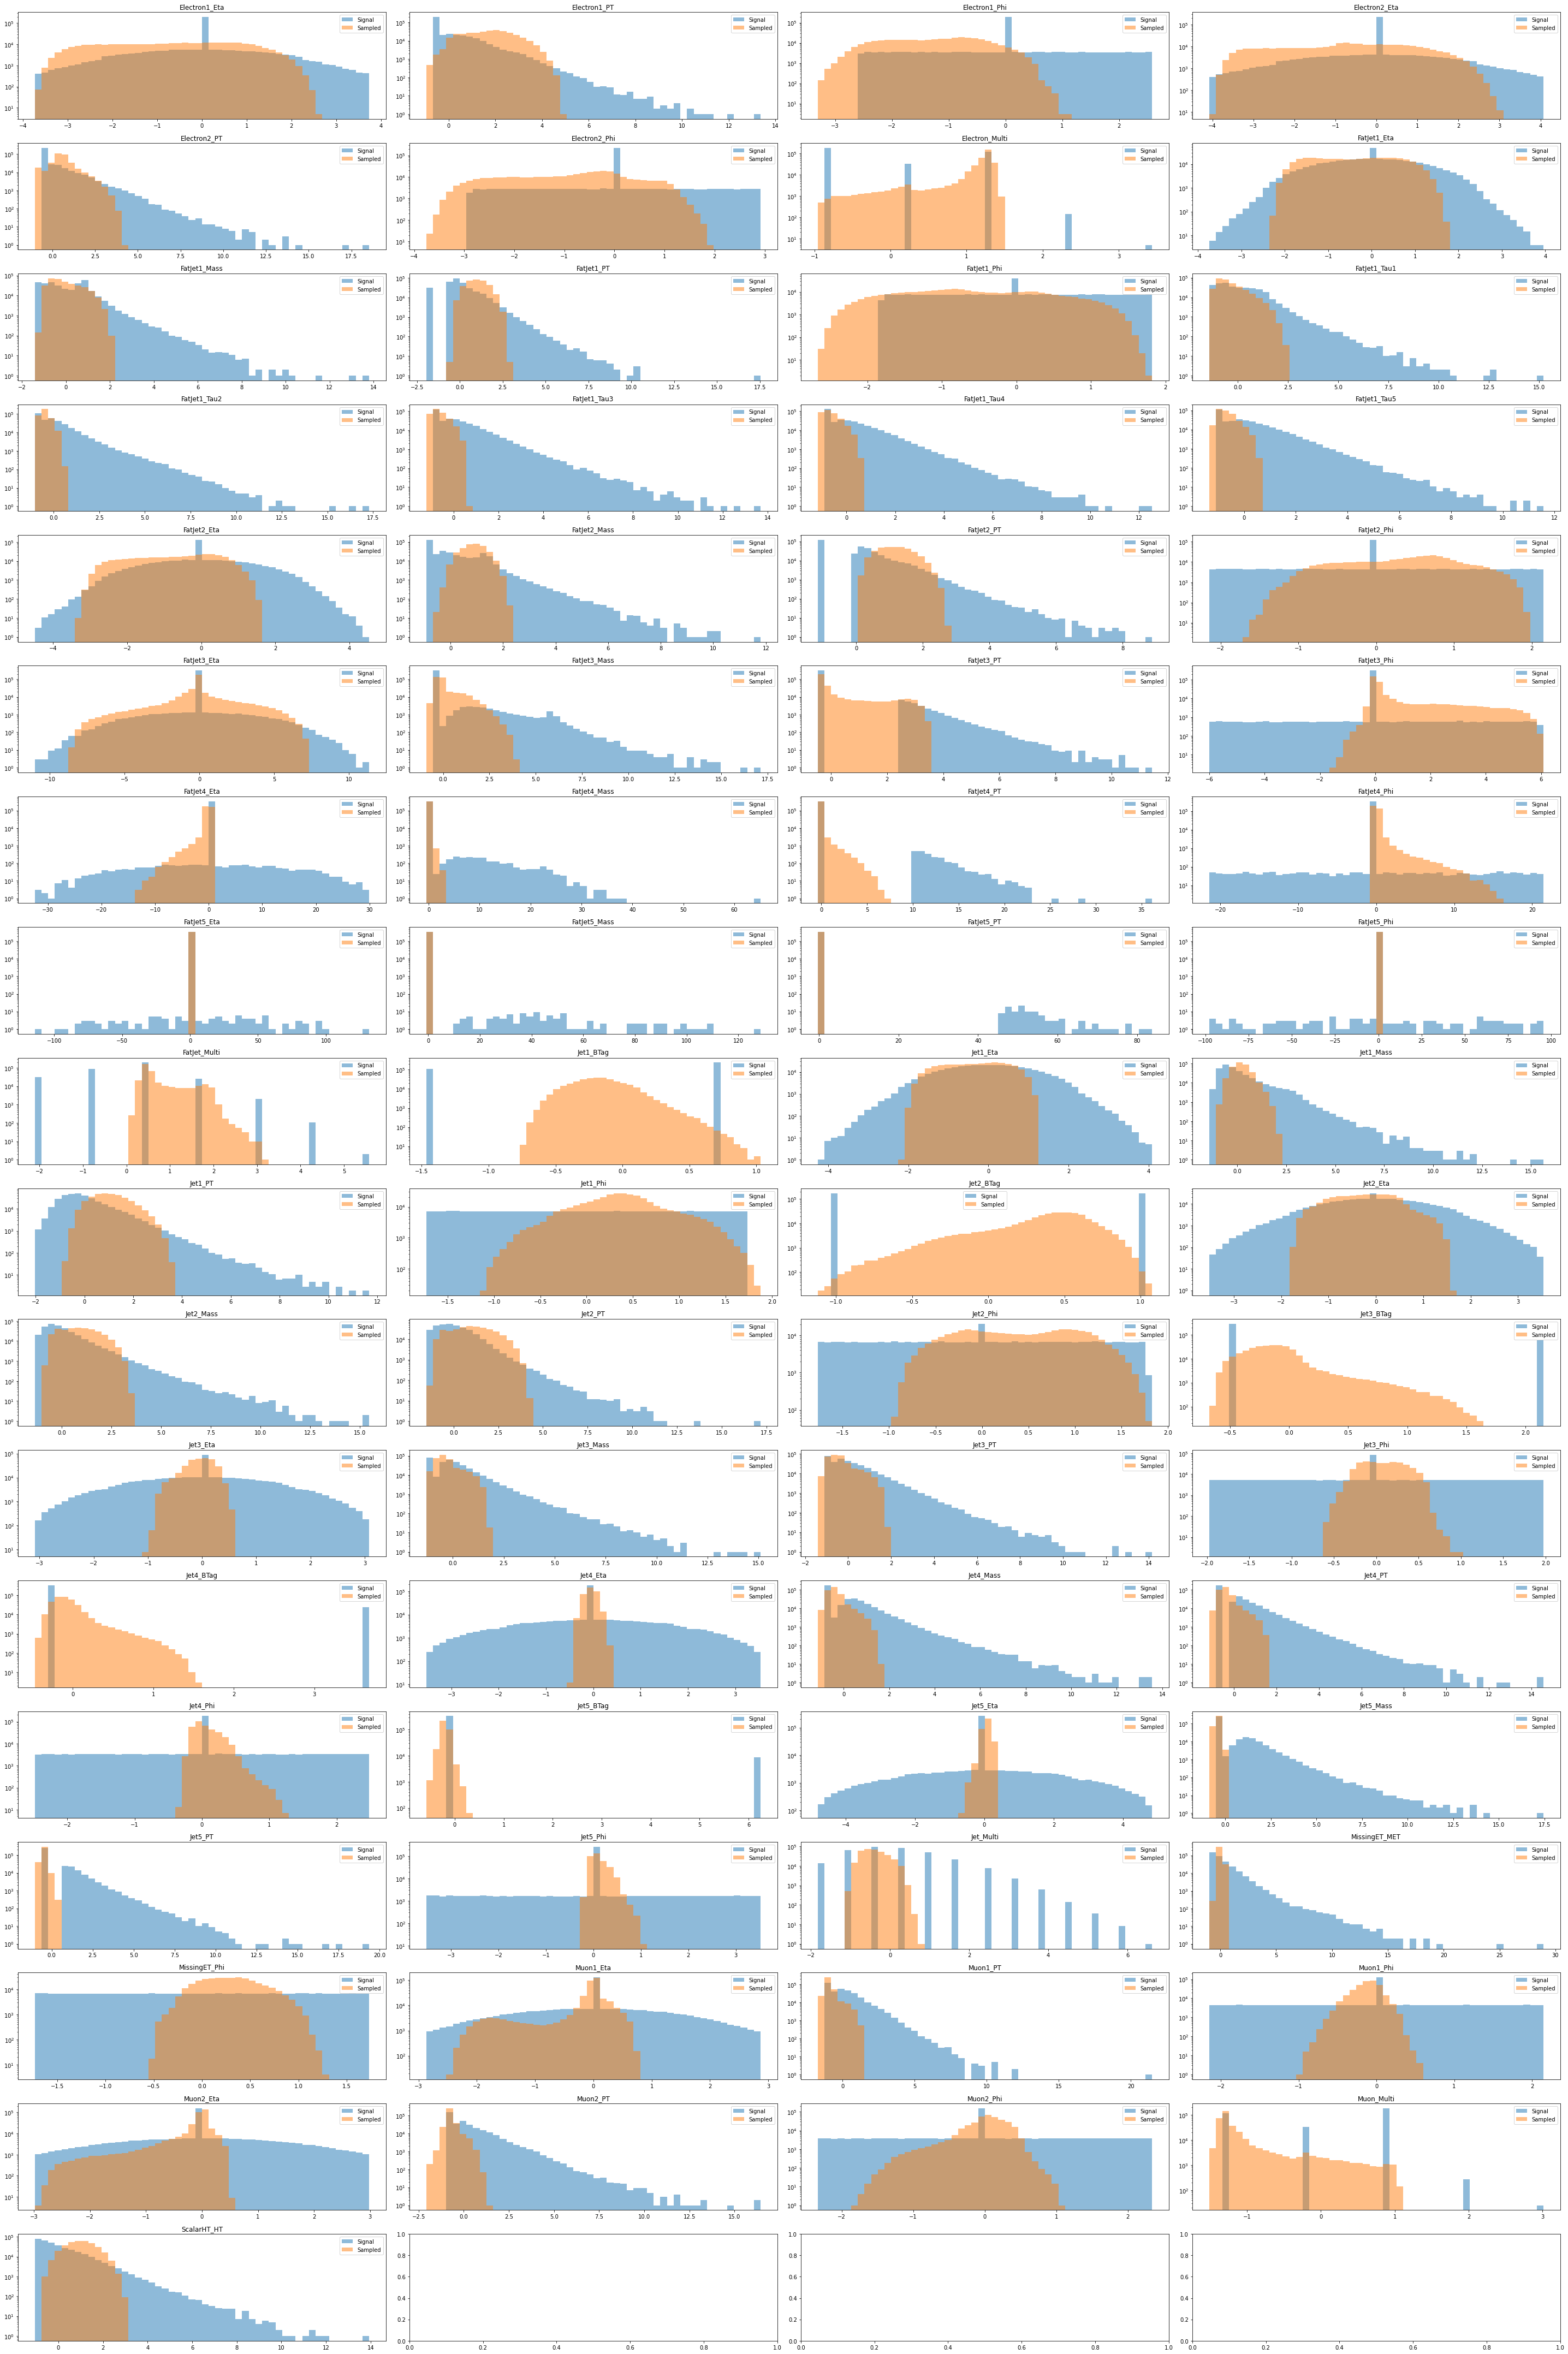

In [13]:
plot_graphs2(bkg, sample)

In [14]:
objective_score = 0
for idx in range(bkg.shape[1]):
    feature = bkg.columns[idx]
    if "Tag" in feature or "Multi" in feature:
        #print("Feature", feature, "é inteiro")
        objective_score += compare_integer(bkg.to_numpy()[:, idx], bkg_weights.to_numpy(), sample.to_numpy()[:, idx], np.ones(bkg_weights.shape))
    else:
        #print("Feature", feature, "é continuo")
        objective_score += compare_continuous(bkg.to_numpy()[:, idx], bkg_weights.to_numpy(), sample.to_numpy()[:, idx], np.ones(bkg_weights.shape))
print("WD Score:", objective_score)

WD Score: 13.79492872217451


## Bkg Data vs Reconstruction

In [15]:
def plot_graphs3(first, second, first_name="Signal", second_name="Sampled", bins=50, num_cols=4, num_features=69):

    R2_SCORE = 0

    # Reshape
    first = first.reshape(num_features, -1)
    second = second.reshape(num_features, -1)

    # Plot creation
    num_rows = int(np.ceil((num_features - 1) / num_cols)) +1
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(40, 60))
    i= 0

    for x in tqdm(range(num_features), total=num_features, desc="Processing..."):

        # Plot  
        row, col = int(i/num_cols), i%num_cols
        #print(row, col, i)
        i += 1


        # Define histogram range
        hist_min = min(first[x].min(), second[x].min())
        hist_max = max(first[x].max(), second[x].max())
        hist_range = (hist_min, hist_max)


        ax[row, col].set_title(x)
        ax[row, col].set_yscale('log')
        
        ax[row, col].hist(first[x], bins=bins, alpha=0.5, label=first_name, range=hist_range)
        ax[row, col].hist(second[x], bins=bins, alpha=0.5, label=second_name,  range=hist_range)

        x = x.cpu().numpy()
        output = output.cpu().numpy()

        #print("Input", np.isnan(x).any())
        #print("Output", np.isnan(output).any())


        #R2_SCORE += r2_score(first[x],second[x])
        

    fig.tight_layout()
    #plt.savefig('1_explore_data.png', bbox_inches='tight', dpi=100)
    plt.show()
    #print("R2_SCORE:", R2_SCORE/num_features)

Processing...:   0%|          | 0/69 [00:00<?, ?it/s]

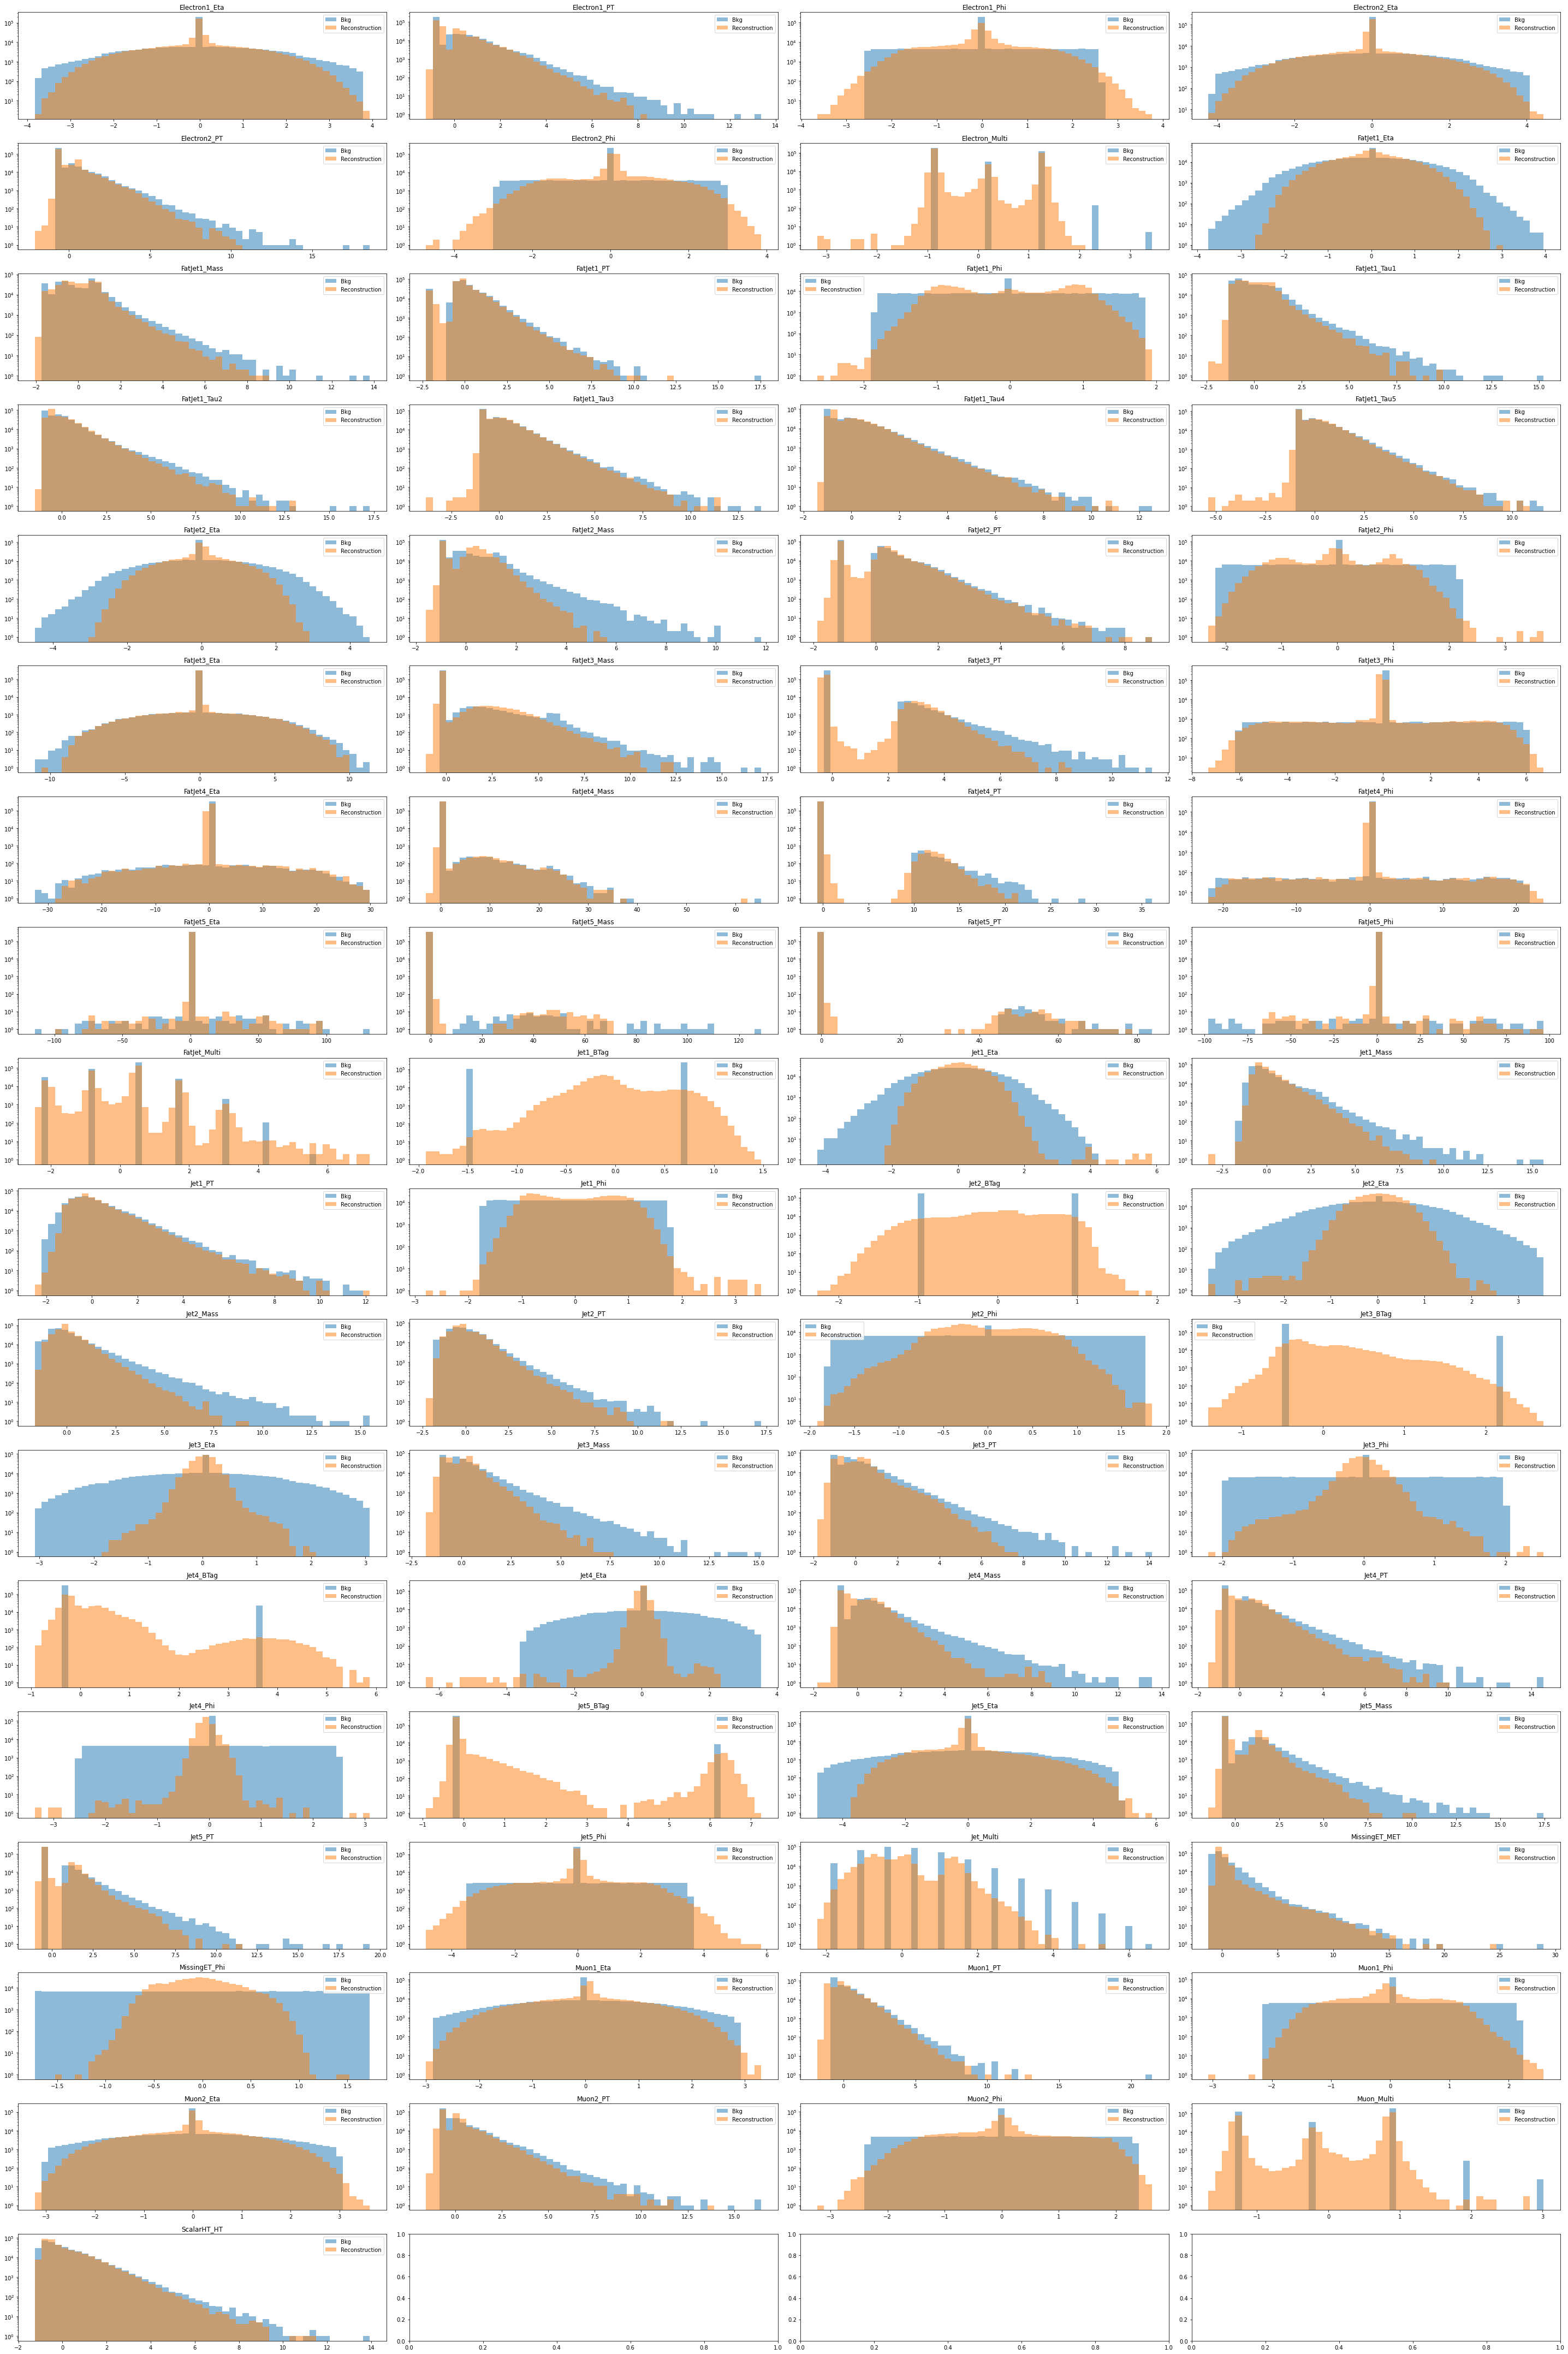

In [16]:
plot_graphs2(bkg, pd.DataFrame(x_out, columns=bkg.columns), first_name="Bkg", second_name="Reconstruction")

In [17]:
print("R2 Score:", r2_score(bkg.to_numpy(), x_out, sample_weight=bkg_weights.to_numpy()))

R2 Score: 0.6523292490111295


## Plot error distributions and ROC Scores

Load data

In [18]:
bkg = _dataset(category='validation',variant='bkg').all_data() # The data category is validation because I accidentally used 'test' on the validation step while training
signal = _dataset(category='all',variant='signal').all_data()
# signal.drop(columns=['weights'], inplace=True)

data = pd.concat([signal, bkg])
del signal, bkg

Plot

In [19]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix,precision_score

def plot_graphs3(data, bins=50, num_cols=4):
    # Plot creation
    features = list(data['name'].unique())

    distributions = {}

    for x in tqdm(features, total=len(features), desc="Processing..."):

        ## Get the relevant data
        sData = data.loc[data['name'] == x].drop(columns=['name', 'weights'])
        sData = torch.from_numpy(
            sData.to_numpy(dtype=np.float32)
        )

        ## Pass input through model to get the output
        _, _, output, _ = model.test_step(sData)

        ## Calculate the error dist
        error_dist = (sData - output)**2
        del output, sData
        error_dist = error_dist.detach().numpy().sum(axis=1)
        error_dist = np.log(error_dist)
        # Append to list
        distributions[x] = error_dist

    ## Normalize the distributions
    # This way all values should be between 0 and 1

    # x transform
    min_of_dist = min(map(lambda x: min(x), distributions.values()))
    for x in distributions:
        distributions[x] = distributions[x] - min_of_dist
    # scale
    max_of_dist = max(map(lambda x: max(x), distributions.values()))
    for x in distributions:
        distributions[x] = distributions[x] / max_of_dist
    
    ## Plot error distributions
    fig, ax = plt.subplots( figsize=(10,10))
    ax.set_yscale('log')

    for x in tqdm(distributions.keys(), desc="Processing..."):

        hist_range = (0, 1)        

        if x != 'bkg.h5':
            ax.hist(distributions[x], bins=bins, alpha=0.9, label=x.replace(".h5", ""), range=hist_range, histtype=u'step', linewidth=2, density=True)
        else:
            ax.hist(distributions[x], bins=bins, alpha=0.2, label=x.replace(".h5", ""), range=hist_range, density=True)

    ax.autoscale(enable=True) 
    ax.set_title("Error Dist.")
    ax.legend()


    ## Plot ROC Curves
    fig_roc, ax_roc = plt.subplots(figsize=(10,10))
    for x in tqdm(distributions.keys(), desc="Processing..."):
        if x != 'bkg.h5':
            # Set labels
            bkg_labels = np.zeros(distributions['bkg.h5'].shape[0]).astype(int)
            signal_labels = np.ones(distributions[x].shape[0]).astype(int)
            labels = np.concatenate([bkg_labels, signal_labels])

            # Set Scores
            score = np.concatenate([distributions['bkg.h5'], distributions[x]]) 

            # Set weights
            weights = pd.concat([
                                data[data['name'] == "bkg.h5"]['weights'], 
                                data[data['name'] == x]['weights']
                                ])

            # Get Curve
            fpr, tpr, thr = roc_curve(
                    y_true=labels, 
                    y_score=score,
                    sample_weight=weights
                    )
            
            
            ax_roc.plot(fpr, tpr, label=x.replace('.h5', ''))
            ax_roc.plot([0,1],[0,1], 'k--')
   
            print(f"ROC SCORE for {x.replace('.h5', '')}:", 
                    roc_auc_score(y_true=labels, 
                    y_score=score,
                    sample_weight=weights))
            #print(score.min(), score.max())
            #print(np.unique(np.rint(score)))
            print("Confusion matrix:")
            print(confusion_matrix(labels, np.rint(score)))
            print("\n")
    fig_roc.show()
    ax_roc.set_title(f"BKG vs Signals")
    ax_roc.legend()
                

    fig.tight_layout()
    plt.show()

Processing...:   0%|          | 0/8 [00:00<?, ?it/s]

Processing...:   0%|          | 0/8 [00:00<?, ?it/s]

Processing...:   0%|          | 0/8 [00:00<?, ?it/s]

ROC SCORE for hg3000_hq1000: 0.9509698568404008
Confusion matrix:
[[340151    970]
 [ 27201   1539]]


ROC SCORE for wohg_hq1000: 0.953018028428491
Confusion matrix:
[[340151    970]
 [ 27885   1745]]


ROC SCORE for hg3000_hq1200: 0.9494815589540805
Confusion matrix:
[[340151    970]
 [ 24764   1740]]


ROC SCORE for wohg_hq1200: 0.9499210501466927
Confusion matrix:
[[340151    970]
 [ 25267   2042]]


ROC SCORE for fcnc: 0.57828674354826
Confusion matrix:
[[340151    970]
 [100845    586]]


ROC SCORE for hg3000_hq1400: 0.9504555402970618
Confusion matrix:
[[340151    970]
 [ 24791   1883]]


ROC SCORE for wohg_hq1400: 0.9510771954491859
Confusion matrix:
[[340151    970]
 [ 23125   2372]]




<ipython-input-19-780b8fc689f9>:97: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



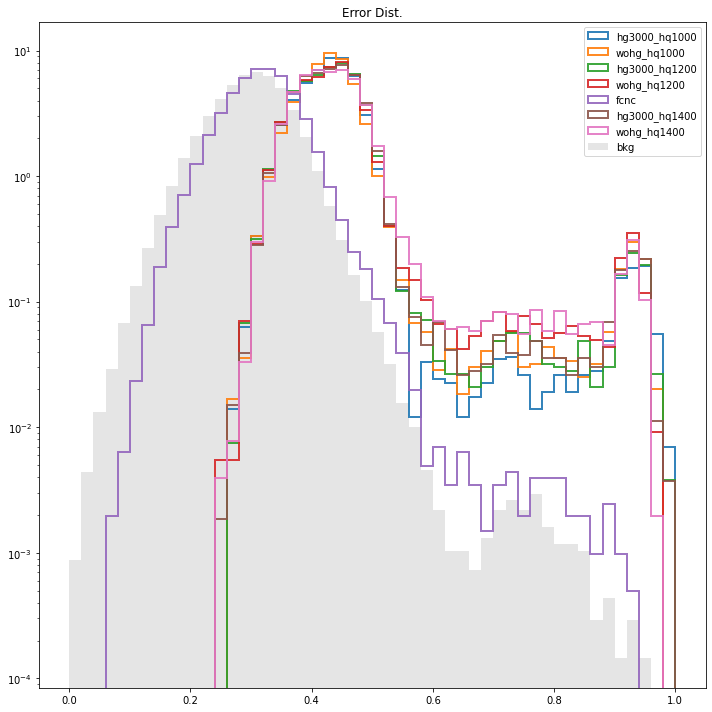

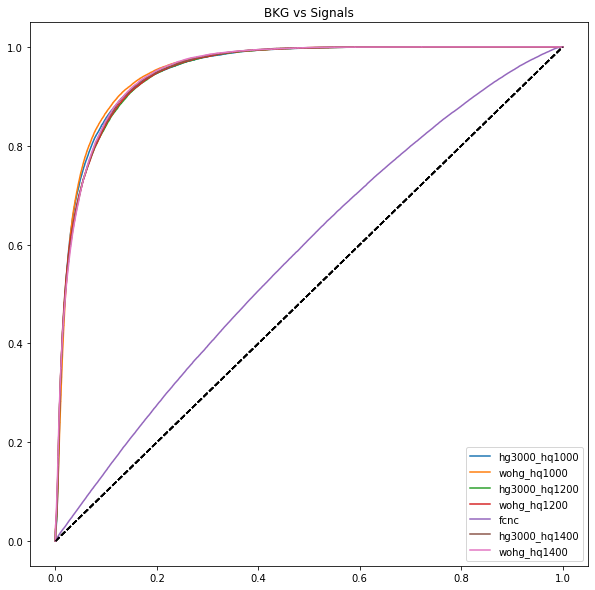

In [20]:
plot_graphs3(data)